In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import matplotlib.pyplot as plt
from scipy.stats import loguniform
import predictive as pred
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
# import datasets
df_chicago = pd.read_csv("data/datasets/df_chicago.csv.zip")

In [3]:
df_chicago_cluster = df_chicago[['start_time_hourly','Trip_Seconds',"Trip_Miles"]]
df_chicago_cluster

,start_time_hourly,Trip_Seconds,Trip_Miles
0,0,900.0,2.7
1,0,240.0,0.4
2,0,1920.0,0.6
3,0,180.0,1.0
4,0,240.0,0.3
...,...,...,...
8974515,23,540.0,1.4
8974516,23,1860.0,5.9
8974517,23,720.0,2.0
8974518,23,660.0,3.5


In [4]:
df_chicago_cluster = df_chicago_cluster[(df_chicago_cluster['Trip_Miles'] < df_chicago_cluster['Trip_Miles'].quantile(0.95))]
df_chicago_cluster = df_chicago_cluster[(df_chicago_cluster['Trip_Seconds'] < df_chicago_cluster['Trip_Seconds'].quantile(0.95))]

In [5]:
df_chicago_cluster

,start_time_hourly,Trip_Seconds,Trip_Miles
0,0,900.0,2.7
1,0,240.0,0.4
3,0,180.0,1.0
4,0,240.0,0.3
5,0,480.0,0.8
...,...,...,...
8974513,23,540.0,4.0
8974514,23,1140.0,5.1
8974515,23,540.0,1.4
8974517,23,720.0,2.0


In [6]:
# Drop unrealistic fast trips
df_chicago_cluster["velocity"] = (df_chicago_cluster["Trip_Miles"]/(df_chicago_cluster["Trip_Seconds"]/3600)).round(2)
df_chicago_cluster = df_chicago_cluster[(df_chicago_cluster['velocity'] < df_chicago_cluster['velocity'].quantile(0.95))]
df_chicago_cluster = df_chicago_cluster[(df_chicago_cluster['velocity'] > df_chicago_cluster['velocity'].quantile(0.05))]
df_chicago_cluster = df_chicago_cluster.drop(['velocity'], axis = 1)

In [11]:
df_chicago_cluster.reset_index(drop = True)

,start_time_hourly,Trip_Seconds,Trip_Miles
0,0,900.0,2.7
1,0,240.0,0.4
2,0,180.0,1.0
3,0,240.0,0.3
4,0,480.0,0.8
...,...,...,...
7247312,23,180.0,0.5
7247313,23,1140.0,5.1
7247314,23,540.0,1.4
7247315,23,720.0,2.0


When researching for the best score to use when deciding which number of cluster to choose for the Gaussian Mixture Model (soft-clustering), we found the Silhouette score and the Bayesian information criterion (BIC).

In [8]:
# method for scaling the data 
def scaling_data(df1):
    
    scaler = StandardScaler()
    df_chicago_scaled = scaler.fit_transform(df1)
    df_chicago_scaled = pd.DataFrame(df_chicago_scaled, columns=df1.columns, 
                                            index=df1.index)
    
    return df_chicago_scaled

In [9]:
df_cluster_scaled = scaling_data(df_chicago_cluster)

In [10]:
df_cluster_scaled

,start_time_hourly,Trip_Seconds,Trip_Miles
0,-1.983130,1.343110,0.787302
1,-1.983130,-1.242093,-0.970516
3,-1.983130,-1.477111,-0.511955
4,-1.983130,-1.242093,-1.046943
5,-1.983130,-0.302019,-0.664808
...,...,...,...
8974512,1.371088,-1.477111,-0.894089
8974514,1.371088,2.283184,2.621546
8974515,1.371088,-0.067001,-0.206247
8974517,1.371088,0.638055,0.252314


### Silhouette score

In [12]:
def silhoutte(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        labels = model_clus.fit_predict(input_data)
        
        clusters.append(k+1)
        scores.append(silhouette_score(input_data, labels = labels, sample_size=1000,random_state=42))
        #defaults: metric=euclidian
        
    return clusters, scores

In [15]:
df_score = df_cluster_scaled.sample(750000, random_state=42)
df_score

,start_time_hourly,Trip_Seconds,Trip_Miles
7859463,-1.983130,0.403036,-1.123370
1567295,-1.983130,0.873073,-1.046943
1532308,-0.670610,-0.537038,-0.511955
8608880,1.225252,-1.477111,-1.215082
1538808,0.350239,-1.242093,-0.817662
...,...,...,...
5094111,-0.670610,-0.772056,-0.129820
1702540,0.496074,-1.477111,-0.741235
7783643,-1.545624,-1.242093,-0.664808
4667153,0.350239,-0.067001,-1.123370


In [16]:
clusters_sil, scores_sil = silhoutte(df_score, 10)

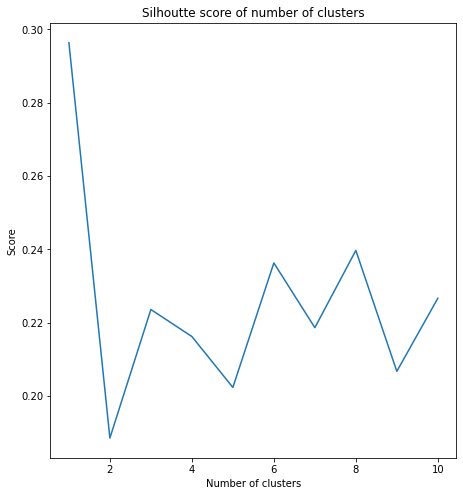

<Figure size 432x288 with 0 Axes>

In [17]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.show()
plt.savefig('silhouttescore')

### Bayesian information criterion (BIC)

In [18]:
def bic(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        model_clus.fit(input_data)
        
        clusters.append(k+1)
        scores.append(model_clus.bic(input_data))

        #defaults: metric=euclidian
        
    return clusters, scores

In [19]:
clusters_bic, scores_bic = bic(df_score, 10)

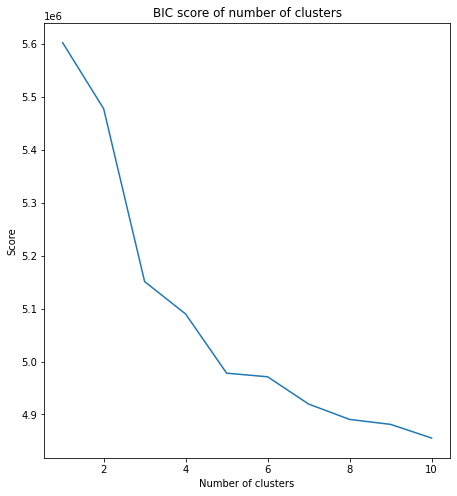

<Figure size 432x288 with 0 Axes>

In [20]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.show()
plt.savefig('BICscore')

In [21]:
gm = GaussianMixture(n_components=6, random_state=42, n_init = 15).fit(df_cluster_scaled)

In [22]:
cluster = gm.predict(df_cluster_scaled)

In [23]:
cluster_prob = gm.predict_proba(df_cluster_scaled)

In [24]:
df_chicago_cluster["cluster"] = cluster

In [25]:
for k in range(5):
    df_chicago_cluster[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [26]:
df_chicago_cluster

,start_time_hourly,Trip_Seconds,Trip_Miles,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob
0,0,900.0,2.7,5,9.241915e-05,3.058123e-19,1.994549e-01,5.906753e-31,3.893079e-257
1,0,240.0,0.4,2,1.320698e-02,2.272388e-24,9.855189e-01,4.903452e-29,2.044949e-05
3,0,180.0,1.0,2,8.551338e-02,1.063691e-25,9.128693e-01,5.616273e-32,2.112221e-40
4,0,240.0,0.3,2,7.928040e-03,3.362586e-24,9.853811e-01,7.761108e-29,5.365695e-03
5,0,480.0,0.8,2,7.312054e-03,2.091962e-21,9.536179e-01,5.872735e-28,8.126666e-18
...,...,...,...,...,...,...,...,...,...
8974512,23,180.0,0.5,3,5.465788e-02,8.863715e-03,7.358218e-96,9.348431e-01,1.817717e-10
8974514,23,1140.0,5.1,1,9.925098e-18,9.669726e-01,8.885553e-100,6.378516e-10,0.000000e+00
8974515,23,540.0,1.4,0,4.581682e-01,2.344592e-01,4.574040e-99,2.592919e-01,2.035371e-68
8974517,23,720.0,2.0,1,1.090692e-01,7.237247e-01,1.035550e-100,1.630681e-02,6.001451e-141


In [27]:
def plot_information_about_clusters(df, feature_list, cluster_column):
    
    fig = plt.figure(figsize=(14, 18))
    
    for i in range(1, len(feature_list)+1):
        plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, i)
        sns.boxplot(y=df[feature_list[i-1]], 
                    x = df[cluster_column], 
                    palette="bright",
                    showmeans=True,
                    meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}).set_title("Cluster - " + feature_list[i-1]).set_fontsize('18')
        plt.tight_layout()
    
    plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, len(feature_list)+1)
    ax = sns.countplot(x=cluster_column, data=df, palette="bright")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Amount")
    ax.set_title('Cluster - Amount',fontsize=18)
    fig.tight_layout()

    for container in ax.containers:
        ax.bar_label(container)

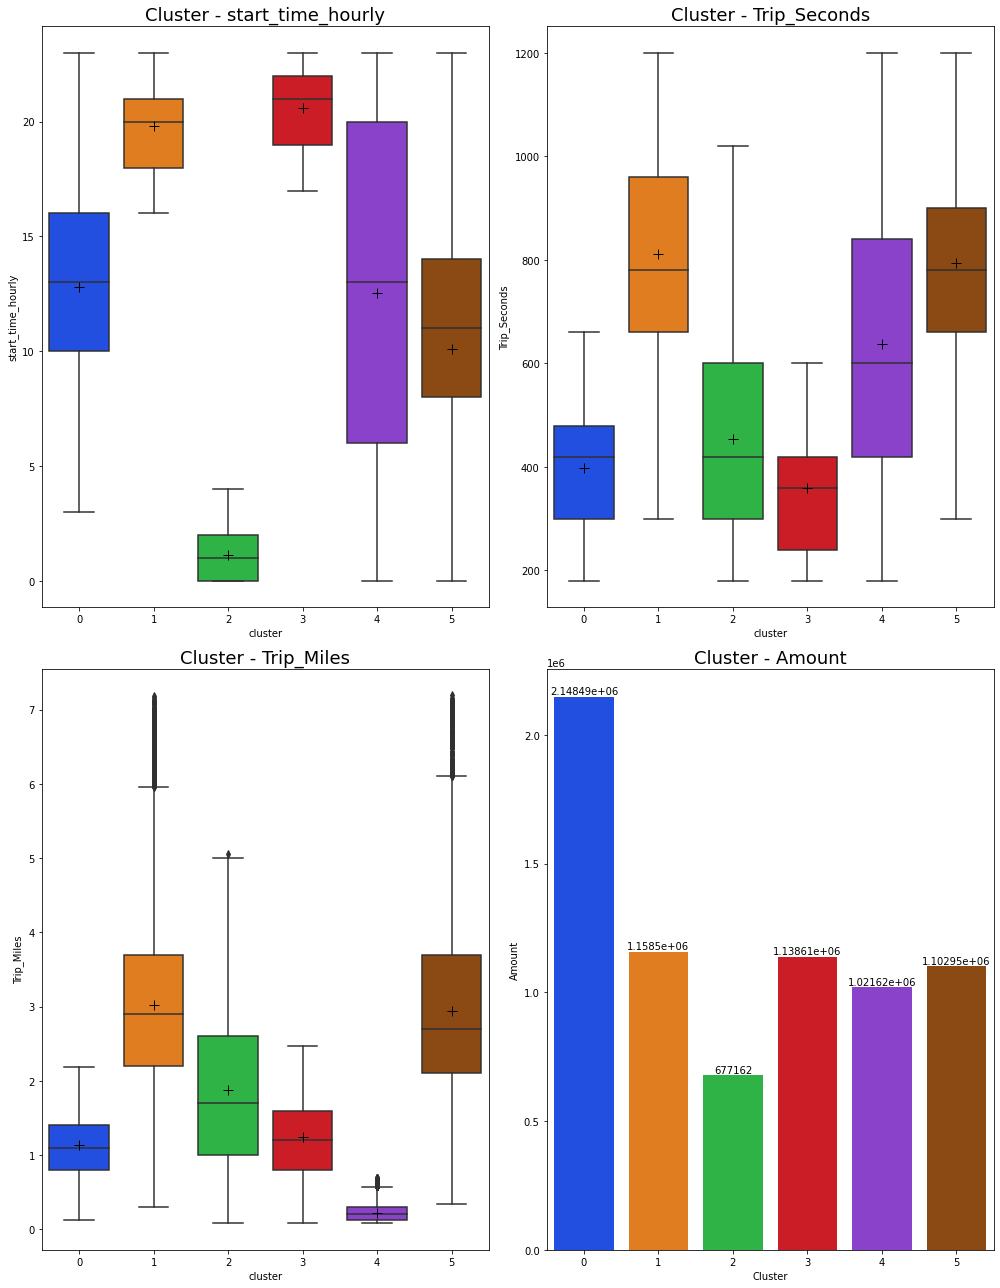

In [28]:
plot_information_about_clusters(df_chicago_cluster, ['start_time_hourly', 'Trip_Seconds', 'Trip_Miles'], 'cluster')

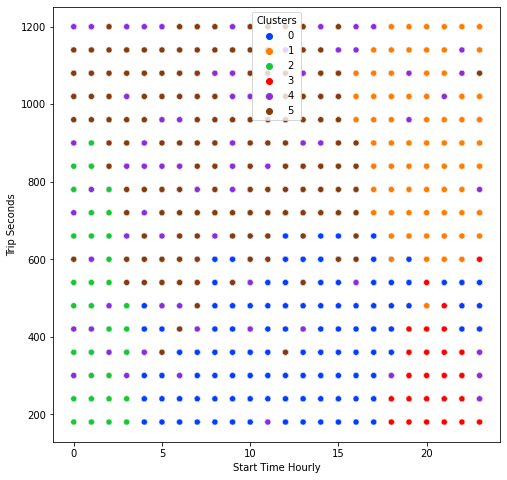

In [29]:
colors = {
    2: '#16C835', #green
    1: '#FF7C00',#orange
    4: '#8B2BE2',#violet
    5: '#843C0C',#brown
    0: '#023EFF',#blue
    6: '#FF1493',#rosa
    3:'#FF0000',#red
    7:'#808080'#grey
    # Add more colors for other clusters if needed
}

# Create the scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Use hue parameter to color the data points based on the 'cluster' column
sns.scatterplot(x='start_time_hourly', y='Trip_Seconds',data=df_chicago_cluster,hue='cluster', palette=colors)

# Add labels and legend
plt.xlabel('Start Time Hourly')
plt.ylabel('Trip Seconds')
plt.legend(title='Clusters', loc='upper center')

# Show the plot
plt.show()

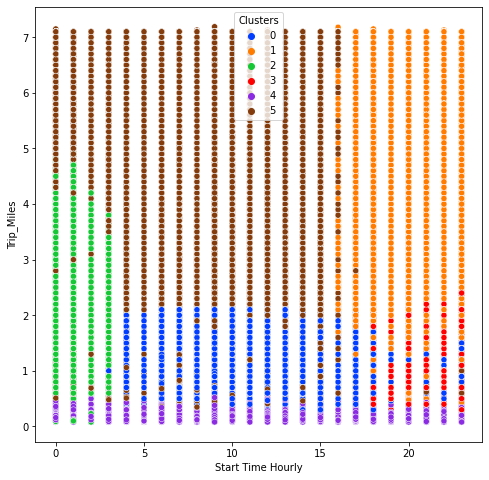

In [30]:
colors = {
    2: '#16C835', #green
    1: '#FF7C00',#orange
    4: '#8B2BE2',#violet
    5: '#843C0C',#brown
    0: '#023EFF',#blue
    6: '#FF1493',#rosa
    3:'#FF0000',#red
    7:'#808080'#grey
    # Add more colors for other clusters if needed
}

# Create the scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Use hue parameter to color the data points based on the 'cluster' column
sns.scatterplot(x='start_time_hourly', y='Trip_Miles', data=df_chicago_cluster, hue='cluster', palette=colors)

# Add labels and legend
plt.xlabel('Start Time Hourly')
plt.ylabel('Trip_Miles')
plt.legend(title='Clusters', loc='upper center')

# Show the plot
plt.show()

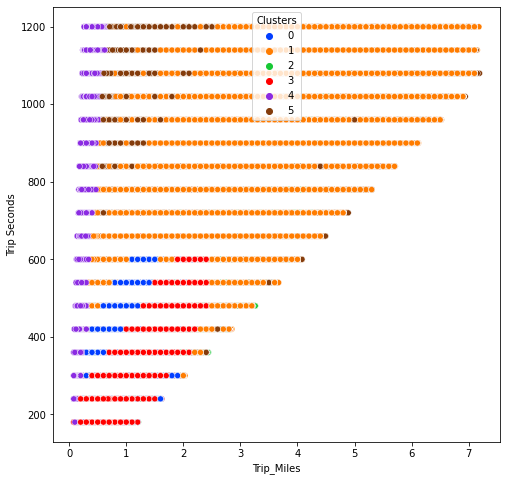

In [31]:
colors = {
    2: '#16C835', #green
    1: '#FF7C00',#orange
    4: '#8B2BE2',#violet
    5: '#843C0C',#brown
    0: '#023EFF',#blue
    6: '#FF1493',#rosa
    3:'#FF0000',#red
    7:'#808080'#grey
    # Add more colors for other clusters if needed
}

# Create the scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Use hue parameter to color the data points based on the 'cluster' column
sns.scatterplot(x='Trip_Miles', y='Trip_Seconds', data=df_chicago_cluster, hue='cluster', palette=colors)

# Add labels and legend
plt.xlabel('Trip_Miles')
plt.ylabel('Trip Seconds')
plt.legend(title='Clusters', loc='upper center')

# Show the plot
plt.show()

In [ ]:
df_chicago['chicago_center'] = [41.881832, -87.623177]

In [ ]:
df_chicago["dist_center_pick"] = df_chicago.apply(lambda row: haversine(row["Pickup_Centroid_Location"], row["end"]), axis=1)
df_chicago["dist_center_drop"] = df_chicago.apply(lambda row: haversine(row["Dropoff_Centroid_Location"], row["end"]), axis=1)
df_chicago[["start", "end", "distance (km)"]]

In [ ]:
df_location = df_chicago['Pickup_Community_Area','Pickup_Centroid_Location',]